## 1 - Importing the libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 2 - Importing the dataset

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

## 3 - EDA

In [4]:
print(df.head())
print('\n')
print(df.info())
print('\n')
print(f"Dataset Shape: {df.shape}")

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [5]:
print(df.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


## Checking 'TotalCharges' Column data type

In [6]:
print(df['TotalCharges'].head(10))
print(df['TotalCharges'].dtype)

0      29.85
1     1889.5
2     108.15
3    1840.75
4     151.65
5      820.5
6     1949.4
7      301.9
8    3046.05
9    3487.95
Name: TotalCharges, dtype: object
object


## 4 - Data Cleaning and Preprocessing

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [8]:
# Convert the column to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill NaN values with 0
df['TotalCharges'] = df['TotalCharges'].fillna(0)

print(df['TotalCharges'].dtype)
print(df['TotalCharges'].isna().sum())

float64
0


In [9]:
df = df.drop(columns=['customerID'])

In [10]:
print(df['Churn'].value_counts(normalize=True))

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


## 5 - Encoding Categorical Variables

In [11]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [12]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

In [15]:
preprocessor = ColumnTransformer(
    transformers =[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='passthrough'
)

In [16]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators = 100, random_state=42))
])


In [17]:
rf_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

## 6- Making a Prediction

In [18]:
y_pred = rf_pipeline.predict(X_test)

In [19]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1036
           1       0.65      0.47      0.54       373

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409

[[941  95]
 [198 175]]


## 7 - Hyperparameter Tuning

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [21]:
param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 10, 15, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__class_weight': [None, 'balanced']

}

In [22]:
random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=2

)

In [23]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.12/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovie...
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'classifier__class_weight': [None,
                                                                     'balanced'],
                                        'classifier__max_depth': [5, 10, 15, 20,
                                                                  None],
                                        'classifier__max_features': ['sqrt',
                                                                     'log2'],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         4],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10],
                                        'classifier__n_estimators': [100, 200,
                                                                     300]},
                   random_state=42, scoring='roc_auc', verbose=2)

In [24]:
print('Best Parameters:', random_search.best_params_)
print('Best Score:', random_search.best_score_)

Best Parameters: {'classifier__n_estimators': 300, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'log2', 'classifier__max_depth': 10, 'classifier__class_weight': None}
Best Score: 0.8414354201719311


## 8 - Making a perediction after tuning

In [25]:
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]

9 - Result after tuning

In [26]:
from sklearn.metrics import roc_auc_score, classification_report
print("Test ROC-AUC:", roc_auc_score(y_test, y_prob_best))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Test ROC-AUC: 0.8642541430745183
              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1036
           1       0.69      0.52      0.59       373

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409

[[948  88]
 [179 194]]


## 10 - Feature Importance

/tmp/ipython-input-1051125363.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


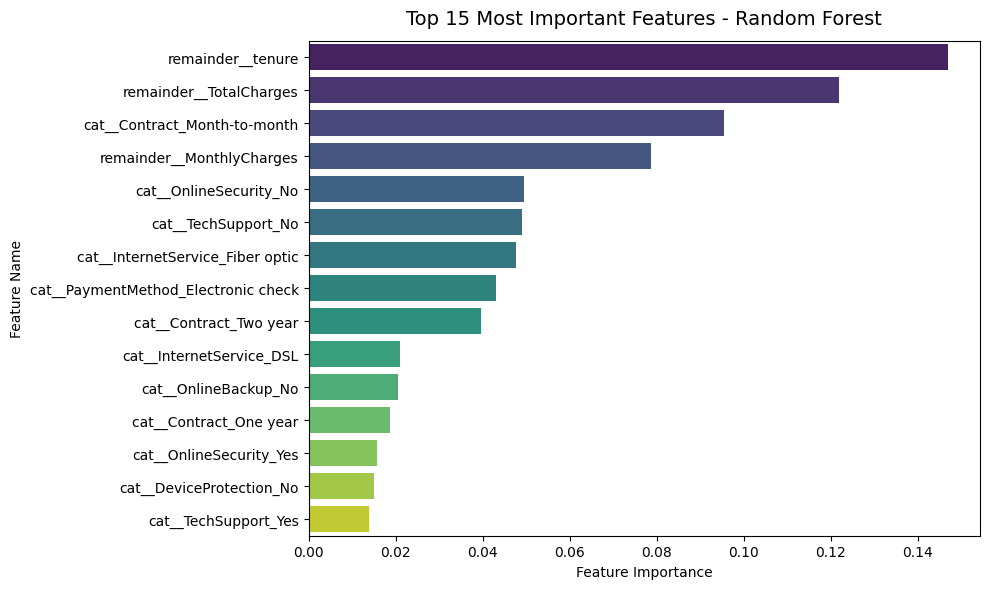

In [27]:
# Extract feature names from the preprocessor
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Extract feature importances from the Random Forest classifier
importances = best_model.named_steps['classifier'].feature_importances_

# Create a DataFrame for better visualization
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 15 most important features
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feat_imp.head(15),
    x='Importance',
    y='Feature',
    palette='viridis'
)
plt.title('Top 15 Most Important Features - Random Forest', fontsize=14, pad=12)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

## 11 - Confusion Matrix

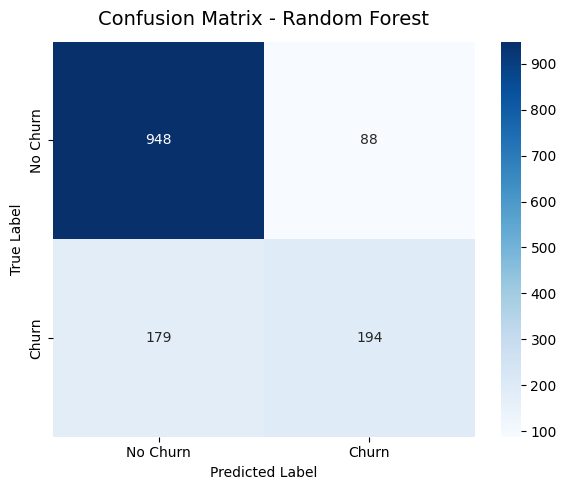

In [30]:
# Get confusion matrix values
cm = confusion_matrix(y_test, y_pred)

# Define class labels
labels = ['No Churn', 'Churn']

# Plot confusion matrix manually
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix - Random Forest', fontsize=14, pad=12)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


##